# Test Linear Lifting via Synthetic LDS
The goal here is to verify that we are able to learn linearizing maps. As such, we play around below in the situation where there is an underlying LDS with some nonlinear observations. We are interested in checking whether we are able to reproduce the underlying LDS.

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
import tqdm

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import LDS, Gym
from extravaganza.sysid import Lifter
from extravaganza.utils import summarize_lds, sample, jkey, opnorm

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmphbld0rxh
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmphbld0rxh/_remote_module_non_scriptable.py


In [20]:
def obs_func(x):
    return jnp.sign(x) * (jnp.abs(x) ** 0.5)   # looks sorta sigmoidal
#     return x

# make g.t. linear system
du = 1  # control dim
ds = 1  # state dim
system = LDS(ds, du, 'none', 'quad', seed=SYSTEM_SEED)
A, B = system.A, system.B
print(summarize_lds(A, B))

# make sysid
T0 = 2000
reset_every = 10
dl = 1

exploration_args = {'scales': 0.5, 'avg_len': 3,}
sysid_args = {
    'obs_dim': ds,
    'control_dim': du,

    'max_traj_len': int(1e6),
    
    'exploration_args': {'random 0.75': exploration_args,
                         'impulse 0.25': exploration_args,
                        },

    'AB_method': 'learned',
    
    'sigma': 0.,
    'determinstic_encoder': True,
    'depth': 8,
    'num_epochs': 4000,
    'lifter_lr': 0.0012,

    'seed': SYSID_SEED,
}
sysid = Lifter(method='nn', state_dim=dl, **sysid_args)

# interaction loop
states = []
control = jnp.zeros(du)
for t in tqdm.trange(T0):
    if t % reset_every == 0: 
        system.reset()
        system.state = sample(jkey(), (ds,), sampling_method='sphere')
        sysid.end_trajectory()
    cost, state = system.interact(control)
    states.append(state)
    obs = obs_func(state)
    control = sysid.explore(cost, obs)
Ahat, Bhat = sysid.end_exploration(wordy=True)

INFO: (LDS) for the LDS we are !!!NOT!!! reporting the costs with the `u.T @ R @ u` part
INFO: (LDS): initial state is [1.0267165]
INFO: (EXPLORER) generating exploration control sequences using ['random', 'impulse'] w.p. [0.75000006 0.25      ]


||A||_op = 0.5867202281951904
||B||_F = 1.1035690307617188
||A-BK||_op = 0.24246156215667725


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1117.31it/s]
INFO: (PC3): using "learned" method to get the AB matrices during each training step
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 6872.43it/s]
INFO: (LIFTER): ending sysid phase at step 2000
INFO: training!
INFO: mean loss for epochs -400 - 0:
INFO: 		guess the control: 0.05468672141432762
INFO: 		simplification: 0.028674237430095673
INFO: mean loss for epochs 0 - 400:
INFO: 		guess the control: 0.051095307348296044
INFO: 		simplification: 0.010576534206047655
INFO: mean loss for epochs 400 - 800:
INFO: 		guess the control: 0.03260471954476088
INFO: 		simplification: 0.004041587867541239
INFO: mean loss for epochs 800 - 1200:
INFO: 		guess the control: 0.0069728782986567235
INFO: 		simplification: 0.001306802551025612
INFO: mean loss for epochs 120

regression:
||A||_op = 0.5654398798942566
||B||_F = 1.0849833488464355
||A-BK||_op = 0.23943865299224854

moments:
||A||_op = 0.52468341588974
||B||_F = 0.058534253388643265
||A-BK||_op = 0.5222188830375671

learned:
||A||_op = 0.5866466760635376
||B||_F = 0.9694896340370178
||A-BK||_op = 0.2764761732521211



In [ ]:
# Ahat, Bhat = sysid.AB['regression'][0], sysid.AB['regression'][1]

In [25]:
# check how well we do at prediction
x = sample(jkey(), (ds,), sampling_method='sphere')
# x = states[np.random.randint(len(states))]
s = sysid.get_state(obs_func(x), jnp.linalg.norm(x) ** 2)
original = s.copy()
for _ in range(1):
    u = sample(jkey(), (du,), sampling_method='ball')
    x = A @ x + B @ u
    s = Ahat @ s + Bhat @ u 
gt = sysid.get_state(obs_func(x), jnp.linalg.norm(x) ** 2)
pred = s.copy()
print(jnp.linalg.norm(gt - original), jnp.linalg.norm(pred - original), jnp.linalg.norm(gt - pred))
print('original:', original) 
print('gt:', gt)
print('pred:', pred)

0.968186 0.9567539 0.011432089
original: [-1.0028405]
gt: [-0.03465452]
pred: [-0.04608661]


||Ahat @ C - C @ A||^2: 	0.00045371614396572113
||Bhat - C @ B||^2: 		0.00038562537520192564
Avg % error: 			197515424.0%


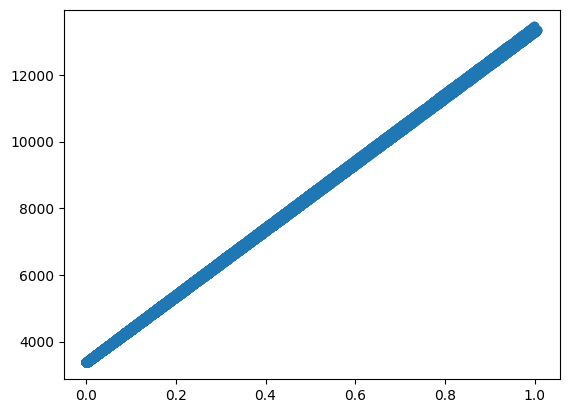

||A @ C - C @ Ahat||^2: 	0.00045197844156064093
||B - C @ Bhat||^2: 		0.00038554109050892293
Avg % error: 			32791343104.0%


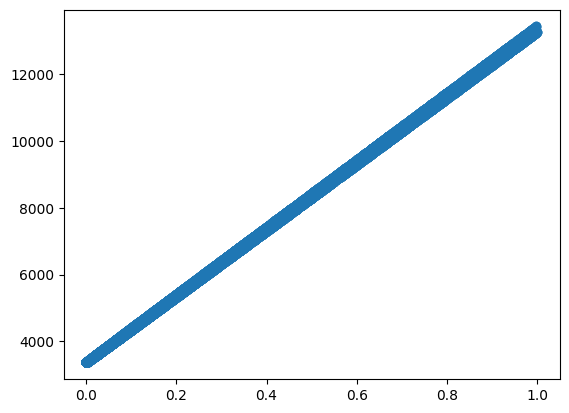

||C_reverse @ C_forward - I_ds||^2 = 	2.3283064365386963e-10
||C_forward @ C_reverse - I_dl||^2 = 	2.3283064365386963e-10


In [26]:
# We know that if we have succeeded, our embedding composed with our observation function is a linear transformation of the original state.
# Below, we regress this transformation, C, and compute some errors with it.

def summarize(A, B, sysid, sampling_method='ball'):
    Ahat, Bhat = sysid.A, sysid.B
    rand_states = sample(jkey(), (5000, ds), sampling_method=sampling_method)
    # rand_states = jnp.stack(states, axis=0)

    # -------- FORWARD DIRECTION, showing that embedding \circ observation is linear ------------------------
    emb = jnp.stack([sysid.get_state(obs_func(r), jnp.linalg.norm(r) ** 2) for r in rand_states], axis=0)

    C_forward = jnp.linalg.lstsq(rand_states, emb, rcond=-1)[0].T
    print('||Ahat @ C - C @ A||^2: \t{}'.format(jnp.linalg.norm(Ahat @ C_forward - C_forward @ A) ** 2))
    print('||Bhat - C @ B||^2: \t\t{}'.format(jnp.linalg.norm(Bhat - C_forward @ B) ** 2))

    residuals = (C_forward[None] @ rand_states[:, :, None]).squeeze() - emb
    residual_norms = jnp.linalg.norm(residuals, axis=-1) ** 2
    state_norms = jnp.linalg.norm(emb, axis=-1) ** 2
    print('Avg % error: \t\t\t{}%'.format(100 * jnp.mean(residual_norms / state_norms)))
    plt.scatter(state_norms, residual_norms)
    plt.show()

    # -------- REVERSE DIRECTION, showing that (embedding \circ observation)^{-1} is linear ------------------------
    C_reverse = jnp.linalg.lstsq(emb, rand_states, rcond=-1)[0].T
    print('||A @ C - C @ Ahat||^2: \t{}'.format(jnp.linalg.norm(A @ C_reverse - C_reverse @ Ahat) ** 2))
    print('||B - C @ Bhat||^2: \t\t{}'.format(jnp.linalg.norm(B - C_reverse @ Bhat) ** 2))

    residuals = (C_reverse[None] @ emb[:, :, None]).squeeze() - rand_states
    residual_norms = jnp.linalg.norm(residuals, axis=-1) ** 2
    state_norms = jnp.linalg.norm(rand_states, axis=-1) ** 2
    print('Avg % error: \t\t\t{}%'.format(100 * jnp.mean(residual_norms / state_norms)))
    plt.scatter(state_norms, residual_norms)
    plt.show()

    print('||C_reverse @ C_forward - I_ds||^2 = \t{}'.format(jnp.linalg.norm(C_reverse @ C_forward - jnp.eye(ds)) ** 2))
    print('||C_forward @ C_reverse - I_dl||^2 = \t{}'.format(jnp.linalg.norm(C_forward @ C_reverse - jnp.eye(dl)) ** 2))

In [32]:
jnp.linalg.svd(C_forward)

(Array([[-1.]], dtype=float32),
 Array([1.000953], dtype=float32),
 Array([[1.]], dtype=float32))

## $d_u=d_s=d_o=1$
We have the observation function given by:
$$obs(x) := sign(x) \cdot \sqrt{|x|}$$

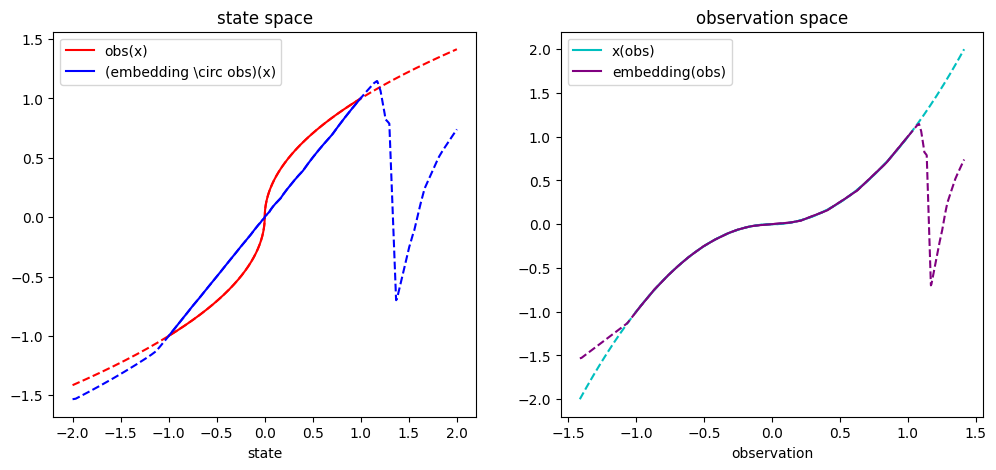

In [29]:
assert ds == 1 and dl == 1
N = 10000
a = 2
b = 1
xs = jnp.linspace(-a, a, N).reshape(-1, 1)
idx1 = jnp.argmax(xs.squeeze() >= -b)
idx2 = jnp.argmax(xs.squeeze() > b)

os = obs_func(xs)
zs = jnp.stack([sysid.get_state(o, jnp.linalg.norm(x) ** 2) for o, x in zip(os, xs)], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(xs, os, 'r--')
ax[0].plot(xs, -zs, 'b--')
ax[1].plot(os, xs, 'c--')
ax[1].plot(os, -zs, '--', color='purple')
xs, os, zs = map(lambda arr: arr[idx1:idx2], [xs, os, zs])
ax[0].plot(xs, os, 'r', label='obs(x)')
ax[0].plot(xs, -zs, 'b', label='(embedding \circ obs)(x)')
ax[1].plot(os, xs, 'c', label='x(obs)')
ax[1].plot(os, -zs, 'purple', label='embedding(obs)')

ax[0].set_title('state space')
ax[0].set_xlabel('state')
ax[1].set_xlabel('observation')
ax[1].set_title('observation space')
ax[0].legend(); ax[1].legend()

## Test on Pendulum
So, we see that we can recreate a synthetic LDS. However, I am not convinced until I see that we are able to reproduce harder systems, such as the pendulum. 

In [ ]:
# # make pendulum
# system = Gym('Pendulum-v1', repeat=2, render=False, seed=SYSTEM_SEED)
# ds = system.state_dim
# du = system.control_dim

# # make sysid
# T0 = 5000
# reset_every = 200
# dl = 6

# exploration_args = {'scales': 0.5, 'avg_len': 5,}
# sysid_args = {
#     'obs_dim': ds,
#     'control_dim': du,

#     'max_traj_len': int(1e6),
    
#     'exploration_args': {'random 0.5': exploration_args,
#                          'impulse 0.5': exploration_args,
#                         },
    
#     'AB_method': 'regression_nograd',

#     'sigma': 0.,
#     'determinstic_encoder': True,
#     'depth': 3,
#     'num_epochs': 5000,
#     'lifter_lr': 0.001,

#     'seed': SYSID_SEED,
# }
# sysid = Lifter(method='nn', state_dim=dl, **sysid_args)

# # interaction loop
# control = jnp.zeros(du)
# for t in tqdm.trange(T0):
#     if t % reset_every == 0: 
#         system.reset()
#         system.state = sample(jkey(), (ds,), sampling_method='ball')
#     cost, state = system.interact(control)
#     control = sysid.explore(cost, state)
# Ahat, Bhat = sysid.end_exploration(wordy=True)

In [ ]:
# # check how well we do at prediction
# system.reset()
# x = system.state.astype(np.float32)
# s = sysid.get_state(x, jnp.linalg.norm(x) ** 2)
# original = s.copy()
# for _ in range(4):
#     u = sample(jkey(), (du,), sampling_method='normal')
#     f, x = system.interact(u)
#     s = Ahat @ s + Bhat @ u
# gt = sysid.get_state(x, jnp.linalg.norm(x) ** 2)
# pred = s.copy()
# print(jnp.linalg.norm(gt - original), jnp.linalg.norm(pred - original), jnp.linalg.norm(gt - pred))
# print('x:', x)
# print('cost:', f)
# print('original:', original)
# print('gt:', gt)
# print('pred:', pred)